In [ ]:
!pip install datasets
!pip install accelerate
!pip install transformers
!pip install tf-keras

In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append('..')
tf.__version__

2025-04-13 20:19:52.326491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 20:19:52.344703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744539592.366238   12009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539592.373705   12009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744539592.391415   12009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

'2.19.0'

In [2]:
# Will result in error, ignore it

if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0
/bin/bash: line 1: nvcc: command not found


I0000 00:00:1744539679.945362   12009 gpu_device.cc:2019] Created device /device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# Skip this step if run locally

# !git clone https://github.com/khamdd/absa-2025
# %cd ./absa-2025
# !mkdir predictions
# !ls

# Constants Setup

In [3]:
RAW_DATASET_PATH = r'../datasets/eval_2014/Restaurants_Train_v2.xml'
TRAIN_PATH = r'../datasets/eval_2014/Restaurants_Train_v2_train.csv'
VAL_PATH = r'../datasets/eval_2014/Restaurants_Train_v2_dev.csv'
TEST_PATH = r'../datasets/eval_2014/Restaurants_Train_v2_test.csv'
PRETRAINED_MODEL = 'bert-base-uncased'
MODEL_NAME = "Restaurant-v1"
MAX_LENGTH = 256
BATCH_SIZE = 10
EPOCHS = 20

In [4]:
from processors.eval2014_processor import Eval2014Loader

Eval2014Loader.xmlToCSV(RAW_DATASET_PATH, TRAIN_PATH)

CSV file generated:../datasets/eval_2014/Restaurants_Train_v2_train.csv


In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.read_csv(TRAIN_PATH)

train_size = 0.7  # 70% for training
test_val_size = 0.3  # Remaining 30% for testing and validation
val_size = 0.5  # 50% of the test_val set for validation

train_data, test_val_data = train_test_split(dataset, test_size=test_val_size, random_state=42)

val_data, test_data = train_test_split(test_val_data, test_size=val_size, random_state=42)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

train_data.to_csv(TRAIN_PATH, index=False)
val_data.to_csv(VAL_PATH, index=False)
test_data.to_csv(TEST_PATH, index=False)

Train size: 2128
Validation size: 456
Test size: 457


In [6]:
raw_datasets = Eval2014Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Review', 'ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'],
        num_rows: 2128
    })
    val: Dataset({
        features: ['Review', 'ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'],
        num_rows: 456
    })
    test: Dataset({
        features: ['Review', 'ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'],
        num_rows: 457
    })
})

# Preprocess and Tokenize data

In [7]:
from processors.english_processor import EnglishTextPreprocessor

eng_preprocessor = EnglishTextPreprocessor()

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokens = tokenizer.encode("This is a auto tokenizer test string")
print('Encode:', tokens, '\nDecode:', tokenizer.decode(tokens))
tokenizer.model_input_names

Encode: [101, 2023, 2003, 1037, 8285, 19204, 17629, 3231, 5164, 102] 
Decode: [CLS] this is a auto tokenizer test string [SEP]


['input_ids', 'token_type_ids', 'attention_mask']

In [9]:
preprocessed_datasets = Eval2014Loader.preprocess_and_tokenize(raw_datasets, eng_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
preprocessed_datasets.save_to_disk('../datasets/preprocessed_restaurant')
display(preprocessed_datasets)
pd.DataFrame({
    'raw_datasets': raw_datasets['train']['Review'][:10],
    'encoded_input_ids': preprocessed_datasets['train']['input_ids'][:10],
    'decoded_input_ids': [tokenizer.decode(preprocessed_datasets['train'][i]['input_ids']) for i in range(10)]
})

[INFO] Tokenizing text data...


Map:   0%|          | 0/2128 [00:00<?, ? examples/s]

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

Map:   0%|          | 0/457 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2128 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/456 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/457 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2128
    })
    val: Dataset({
        features: ['ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 456
    })
    test: Dataset({
        features: ['ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 457
    })
})

,raw_datasets,encoded_input_ids,decoded_input_ids
0,I loved this place!!,"[101, 1045, 3866, 2023, 2173, 102, 0, 0, 0, 0,...",[CLS] i loved this place [SEP] [PAD] [PAD] [PA...
1,The rice was poor quality and was cooked so ba...,"[101, 1996, 5785, 2001, 3532, 3737, 1998, 2001...",[CLS] the rice was poor quality and was cooked...
2,The wine list is interesting and has many good...,"[101, 1996, 4511, 2862, 2003, 5875, 1998, 2038...",[CLS] the wine list is interesting and has man...
3,Plus they made a perfect martini.,"[101, 4606, 2027, 2081, 1037, 3819, 24480, 102...",[CLS] plus they made a perfect martini [SEP] [...
4,I've lived in NYC all my life and had never be...,"[101, 4921, 2063, 2973, 1999, 16392, 2035, 202...",[CLS] ive lived in nyc all my life and had nev...
5,THE FOOD PORTIONS ARE REALLY LARGE.,"[101, 1996, 2833, 8810, 2024, 2428, 2312, 102,...",[CLS] the food portions are really large [SEP]...
6,"As we were leaving, the couple standing by the...","[101, 2004, 2057, 2020, 2975, 1996, 3232, 3061...",[CLS] as we were leaving the couple standing b...
7,They came out over cooked and the cheese was a...,"[101, 2027, 2234, 2041, 2058, 12984, 1998, 199...",[CLS] they came out over cooked and the cheese...
8,Brava La Pizza Fresca!,"[101, 11655, 3567, 2474, 10733, 10424, 2229, 3...",[CLS] brava la pizza fresca [SEP] [PAD] [PAD] ...
9,"If you go for the pre-theatre menu, it's an ev...","[101, 2065, 2017, 2175, 2005, 1996, 3653, 1076...",[CLS] if you go for the pretheatre menu its an...


In [11]:
!pip install --upgrade ipywidgets
!pip install --upgrade jupyter

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab-widgets 1.0.0
    Uninstalling jupyterlab-widgets-1.0.0:
      Successfully uninstalled jupyterlab-widgets-1.0.0
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.8.1
    Uninstalling ipywidgets-7.8.1:
      Successfully uninstalled ipywidgets-7.8.1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Attempting uninstall: jupyter
    Found existing installation: jupyter 1.0.0
    Uninstalling jupyter-1.0.0:
      Successfully uninstalled jupyter-1.0.0


In [12]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('../datasets/preprocessed_restaurant')
preprocessed_datasets = Eval2014Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


Map (num_proc=8):   0%|          | 0/2128 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/456 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/457 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2128
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 456
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 457
    })
})

# Prepare for TensorFlow Training

In [13]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
steps_per_epoch = len(preprocessed_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
print(ASPECT_CATEGORY_NAMES)

['ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service']


In [14]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

I0000 00:00:1744539819.754552   12009 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [15]:
from tf_keras.optimizers.legacy import Adam
from tf_keras.optimizers.schedules import CosineDecay
from tf_keras.callbacks import EarlyStopping

# optimizer = Adam(learning_rate=CosineDecay(
#     initial_learning_rate = 1e-4,
#     warmup_target = 2e-4,
#     warmup_steps = int(total_steps * 0.15), # 15% of total_steps
#     decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
#     alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
# ))

optimizer = Adam(learning_rate=1e-4)

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, # Stop if no improvement after 3 epochs
    restore_best_weights = True,
    verbose = 1
)

# Fine Tuning with TensorFlow

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20


E0000 00:00:1744539838.552601   12450 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539838.557249   12450 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744539838.558271   12445 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539838.561799   12445 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744539838.563486   12443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539838.565208   12449 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factor

213/213 [==============================] - ETA: 0s - loss: 0.2039

E0000 00:00:1744539969.706183   12810 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539969.708504   12813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539969.709687   12814 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539969.710552   12810 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744539969.711347   12812 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539969.711435   12811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory f

213/213 [==============================] - 154s 655ms/step - loss: 0.2039 - val_loss: 0.1567
Epoch 2/20


E0000 00:00:1744539983.092157   12950 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539983.093143   12947 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539983.094263   12946 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744539983.097006   12947 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744539983.098109   12950 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744539983.098100   12948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factor

213/213 [==============================] - ETA: 0s - loss: 0.1109

E0000 00:00:1744540109.349291   13181 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540109.353466   13184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540109.353524   13181 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540109.354505   13180 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540109.357426   13184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540109.358000   13182 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factor

213/213 [==============================] - 139s 639ms/step - loss: 0.1109 - val_loss: 0.1700
Epoch 3/20


E0000 00:00:1744540122.663534   13314 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540122.667522   13314 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540122.669850   13312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540122.673904   13312 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744540122.677725   13314 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744540122.677773   13314 computation_placer.cc:177] computation placer already registered. Please check li

213/213 [==============================] - ETA: 0s - loss: 0.0701

E0000 00:00:1744540248.920904   13537 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540248.921680   13538 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540248.925273   13540 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540248.925321   13537 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540248.929240   13540 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540248.930061   13542 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factor

213/213 [==============================] - 140s 641ms/step - loss: 0.0701 - val_loss: 0.1773
Epoch 4/20


E0000 00:00:1744540262.182289   13672 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540262.191899   13672 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540262.194642   13673 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540262.194750   13675 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540262.198745   13675 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540262.198795   13673 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register fact

213/213 [==============================] - ETA: 0s - loss: 0.0434

E0000 00:00:1744540388.899535   13904 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540388.901661   13902 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540388.903488   13904 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540388.910498   13902 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744540388.911099   13907 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744540388.911270   13909 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factor

213/213 [==============================] - 139s 640ms/step - loss: 0.0434 - val_loss: 0.2107
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


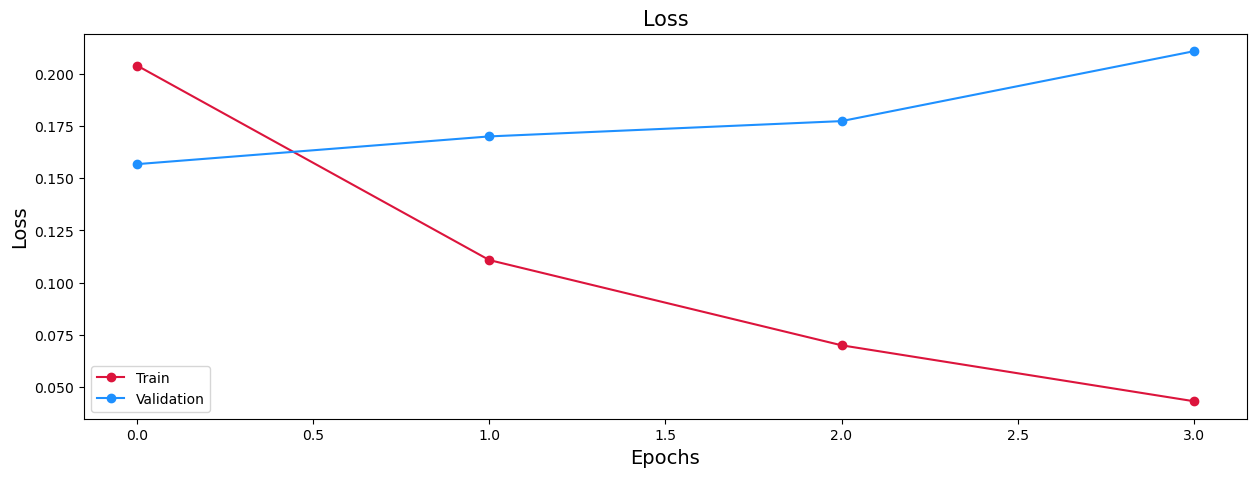

CPU times: user 5min 12s, sys: 1min 21s, total: 6min 33s
Wall time: 9min 48s


In [16]:
%%time
from acsa_model import ABSA2025MultiTask
from helper import plot_training_history
model = ABSA2025MultiTask(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer, name=MODEL_NAME)

history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

model.save_weights(f'./weights/{MODEL_NAME}/{MODEL_NAME}', save_format='tf')
plot_training_history(history)